# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1PTWr43CZS6tdWidtYa0zIEgbdXq6Y0G3?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import tensorflow as tf
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
num = df.shape[0]
for col in subdf:
  minimum = min(subdf[col])
  maximum = max(subdf[col])
  print("\n" + str(col).upper())
  print("Average: " + str((np.sum(subdf[col]))/num))
  print("Min: " + str(minimum))
  print("Max: " + str(maximum))
  df[col] = (subdf[col] - minimum) / (maximum-minimum)

df[:3]


AGE
Average: 38.58164675532078
Min: 17
Max: 90

YREDU
Average: 10.0806793403151
Min: 1
Max: 16

CAPGAIN
Average: 1077.6488437087312
Min: 0
Max: 99999

CAPLOSS
Average: 87.303829734959
Min: 0
Max: 4356

WORKHR
Average: 40.437455852092995
Min: 1
Max: 99


,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
count_female = (df["sex"] == " Female").sum()
count_male = (df["sex"] == " Male").sum()
count = (df["sex"]).shape[0]
percent_female = (count_female/count)*100
percent_male = (count_male/count)*100

print("Percent Male: " + str(round(percent_male,2)) + "%")
print("Percent Female: " + str(round(percent_female,2)) + "%")

Percent Male: 66.92%
Percent Female: 33.08%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

print("Num records missing features: " + str(df_with_missing.shape[0]))

numer = df_with_missing.shape[0]
denom = df.shape[0]
print("Percent of records removed: " + str((round(numer/denom, 4))*100) + "%")

Num records missing features: 1843
Percent of records removed: 5.66%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
newSet = set(df_not_missing["work"])
print(newSet)

{' State-gov', ' Federal-gov', ' Private', ' Self-emp-not-inc', ' Without-pay', ' Local-gov', ' Self-emp-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print("Number of Columns: " + str(data.shape[1]))

Number of Columns: 57


The number of columns represents the total number of possible features in the data set


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
np.random.shuffle(datanp)
# print(datanp)

# todo
# print(len(datanp))
lengthTrain = int(len(datanp)*0.7)
lengthTest = int(len(datanp)*0.15)
trainData, testData, valData= datanp[:21503], datanp[lengthTrain:(lengthTrain+lengthTest+1)], datanp[(lengthTrain+lengthTest+1):]
print("Training Dataset Size:", len(trainData))
print("Testing Dataset Size:", len(testData))
print("Validation Dataset Size:", len(valData))


Training Dataset Size: 21503
Testing Dataset Size: 4608
Validation Dataset Size: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AutoEncoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 30)
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
# Since we used one hot embedding the output of the data needs to be in 0 and 1 which is done y the sigmoid activtion function

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def get_model_name(name, batch_size, learning_rate, num_epochs):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   num_epochs)
    return path

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4, batch_size=128):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)
        train_loss[epoch] = 1-train_acc[epoch]
        val_loss[epoch] = 1-val_acc[epoch]

        print(("Epoch {}: Train acc: {:.4}, Train loss: {:.4} | Validation acc: {:.4}, Validation loss: {:.4}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name("AutoEncoder", batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train acc: 0.3941, Train loss: 0.6059 | Validation acc: 0.3921, Validation loss: 0.6079
Epoch 2: Train acc: 0.4463, Train loss: 0.5537 | Validation acc: 0.4456, Validation loss: 0.5544
Epoch 3: Train acc: 0.4586, Train loss: 0.5414 | Validation acc: 0.4576, Validation loss: 0.5424
Epoch 4: Train acc: 0.4579, Train loss: 0.5421 | Validation acc: 0.4561, Validation loss: 0.5439
Epoch 5: Train acc: 0.4547, Train loss: 0.5453 | Validation acc: 0.453, Validation loss: 0.547
Epoch 6: Train acc: 0.4897, Train loss: 0.5103 | Validation acc: 0.4874, Validation loss: 0.5126
Epoch 7: Train acc: 0.5191, Train loss: 0.4809 | Validation acc: 0.5161, Validation loss: 0.4839
Epoch 8: Train acc: 0.5317, Train loss: 0.4683 | Validation acc: 0.5311, Validation loss: 0.4689
Epoch 9: Train acc: 0.5395, Train loss: 0.4605 | Validation acc: 0.5367, Validation loss: 0.4633
Epoch 10: Train acc: 0.5469, Train loss: 0.4531 | Validation acc: 0.5452, Validation loss: 0.4548
Finished Training
Total time el

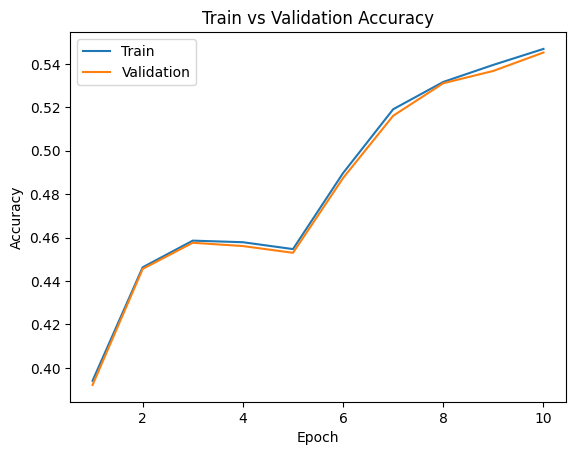

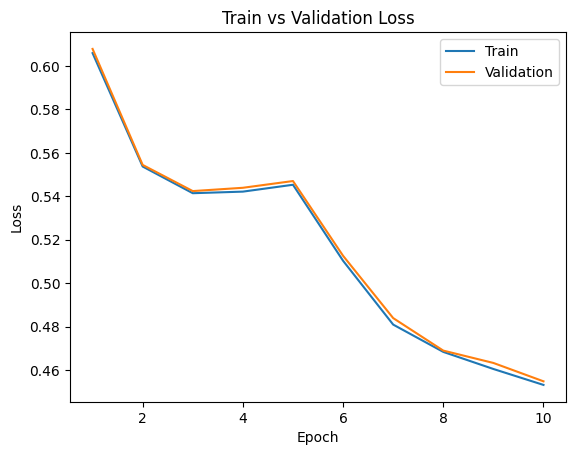

In [ ]:
train_loader = torch.utils.data.DataLoader(trainData, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valData, batch_size=128, shuffle=True)

model = AutoEncoder()
train(model, train_loader, valid_loader, num_epochs=10)

#PLOTTING
model_path1 = get_model_name("AutoEncoder", batch_size=128, learning_rate=0.0001, num_epochs=9)
plot_training_curve(model_path1)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
# Increase the number of epochs to allow the model to train more.
# Decrease the batch size to try and make the validation and trainind data more distinct
model1 = AutoEncoder()

train(model1, train_loader, valid_loader, num_epochs = 50, batch_size=64)

Epoch 1: Train acc: 0.3941, Train loss: 0.6059 | Validation acc: 0.3921, Validation loss: 0.6079
Epoch 2: Train acc: 0.4461, Train loss: 0.5539 | Validation acc: 0.4453, Validation loss: 0.5547
Epoch 3: Train acc: 0.4586, Train loss: 0.5414 | Validation acc: 0.4576, Validation loss: 0.5424
Epoch 4: Train acc: 0.4572, Train loss: 0.5428 | Validation acc: 0.4553, Validation loss: 0.5447
Epoch 5: Train acc: 0.4548, Train loss: 0.5452 | Validation acc: 0.453, Validation loss: 0.547
Epoch 6: Train acc: 0.4902, Train loss: 0.5098 | Validation acc: 0.4882, Validation loss: 0.5118
Epoch 7: Train acc: 0.5148, Train loss: 0.4852 | Validation acc: 0.5119, Validation loss: 0.4881
Epoch 8: Train acc: 0.5345, Train loss: 0.4655 | Validation acc: 0.5319, Validation loss: 0.4681
Epoch 9: Train acc: 0.5424, Train loss: 0.4576 | Validation acc: 0.5408, Validation loss: 0.4592
Epoch 10: Train acc: 0.547, Train loss: 0.453 | Validation acc: 0.5451, Validation loss: 0.4549
Epoch 11: Train acc: 0.5529, Trai

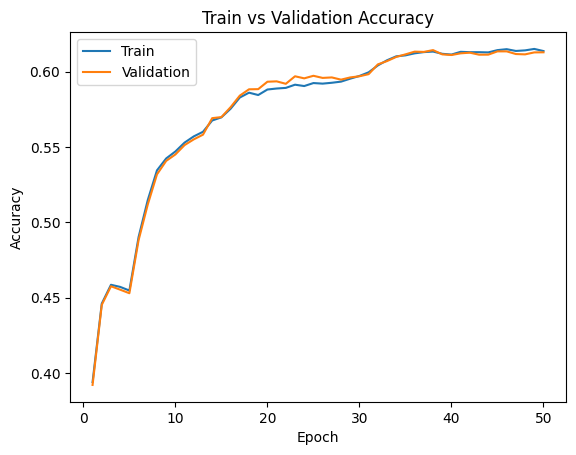

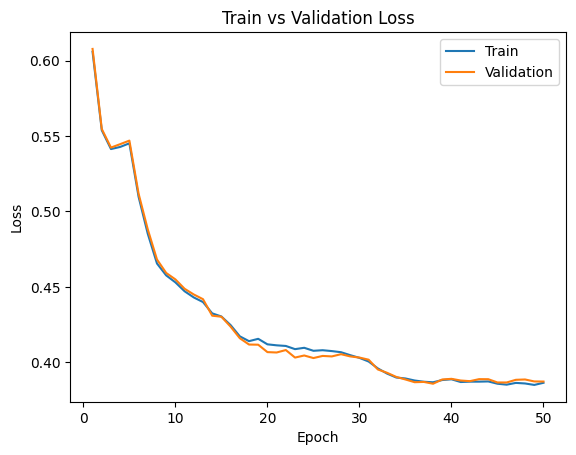

In [ ]:
model_path1 = get_model_name("AutoEncoder", batch_size=64, learning_rate=0.0001, num_epochs=49)
plot_training_curve(model_path1)

In [ ]:
# Increase epochs to allow model to train more
# Increase learning rate to allow model to train faster
# Decrease batch size again to make distinction between validation and trainind curvres
model2 = AutoEncoder()

train(model2, train_loader, valid_loader, num_epochs = 75, learning_rate=0.001, batch_size=32)

Epoch 1: Train acc: 0.5484, Train loss: 0.4516 | Validation acc: 0.5478, Validation loss: 0.4522
Epoch 2: Train acc: 0.5771, Train loss: 0.4229 | Validation acc: 0.5795, Validation loss: 0.4205
Epoch 3: Train acc: 0.6131, Train loss: 0.3869 | Validation acc: 0.6136, Validation loss: 0.3864
Epoch 4: Train acc: 0.6072, Train loss: 0.3928 | Validation acc: 0.6078, Validation loss: 0.3922
Epoch 5: Train acc: 0.6091, Train loss: 0.3909 | Validation acc: 0.6084, Validation loss: 0.3916
Epoch 6: Train acc: 0.6184, Train loss: 0.3816 | Validation acc: 0.6161, Validation loss: 0.3839
Epoch 7: Train acc: 0.6187, Train loss: 0.3813 | Validation acc: 0.614, Validation loss: 0.386
Epoch 8: Train acc: 0.6319, Train loss: 0.3681 | Validation acc: 0.6275, Validation loss: 0.3725
Epoch 9: Train acc: 0.6201, Train loss: 0.3799 | Validation acc: 0.6179, Validation loss: 0.3821
Epoch 10: Train acc: 0.6274, Train loss: 0.3726 | Validation acc: 0.6241, Validation loss: 0.3759
Epoch 11: Train acc: 0.6271, Tr

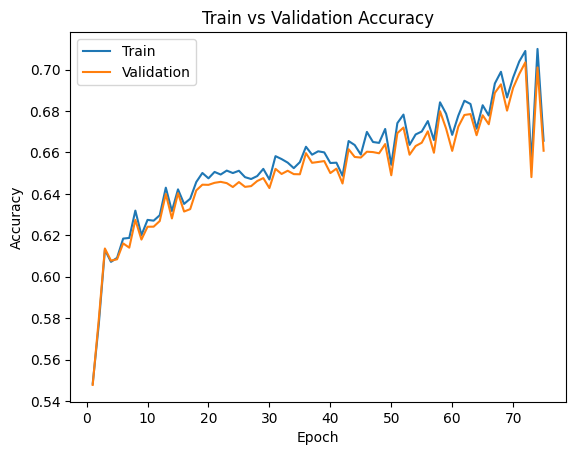

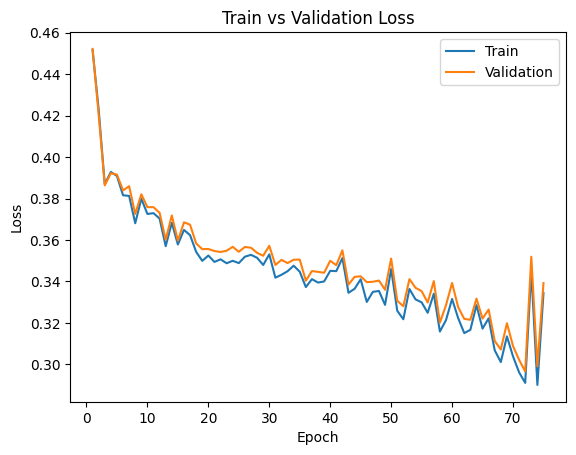

In [ ]:
model_path1 = get_model_name("AutoEncoder", batch_size=32, learning_rate=0.001, num_epochs=74)
plot_training_curve(model_path1)

In [ ]:
# Increase the epochs to allow model to learn weights
# Decrease learning rate to decrease fluctuation in learning
model3 = AutoEncoder()

train(model3, train_loader, valid_loader, num_epochs = 100, learning_rate=0.0005, batch_size=32)

Epoch 1: Train acc: 0.467, Train loss: 0.533 | Validation acc: 0.4664, Validation loss: 0.5336
Epoch 2: Train acc: 0.5611, Train loss: 0.4389 | Validation acc: 0.5598, Validation loss: 0.4402
Epoch 3: Train acc: 0.5764, Train loss: 0.4236 | Validation acc: 0.5784, Validation loss: 0.4216
Epoch 4: Train acc: 0.5963, Train loss: 0.4037 | Validation acc: 0.5976, Validation loss: 0.4024
Epoch 5: Train acc: 0.6121, Train loss: 0.3879 | Validation acc: 0.6115, Validation loss: 0.3885
Epoch 6: Train acc: 0.616, Train loss: 0.384 | Validation acc: 0.6138, Validation loss: 0.3862
Epoch 7: Train acc: 0.6171, Train loss: 0.3829 | Validation acc: 0.6157, Validation loss: 0.3843
Epoch 8: Train acc: 0.6154, Train loss: 0.3846 | Validation acc: 0.6148, Validation loss: 0.3852
Epoch 9: Train acc: 0.6199, Train loss: 0.3801 | Validation acc: 0.6174, Validation loss: 0.3826
Epoch 10: Train acc: 0.622, Train loss: 0.378 | Validation acc: 0.6196, Validation loss: 0.3804
Epoch 11: Train acc: 0.6242, Train 

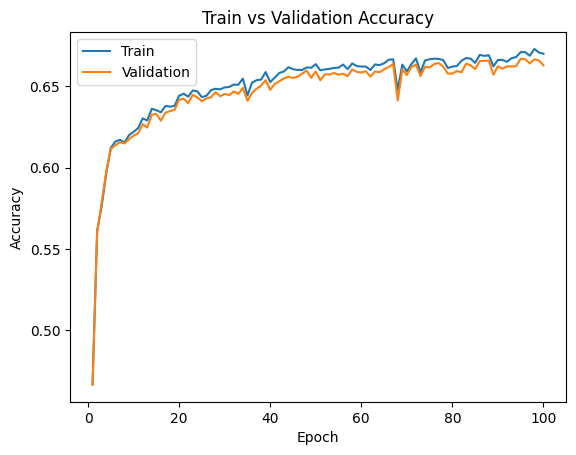

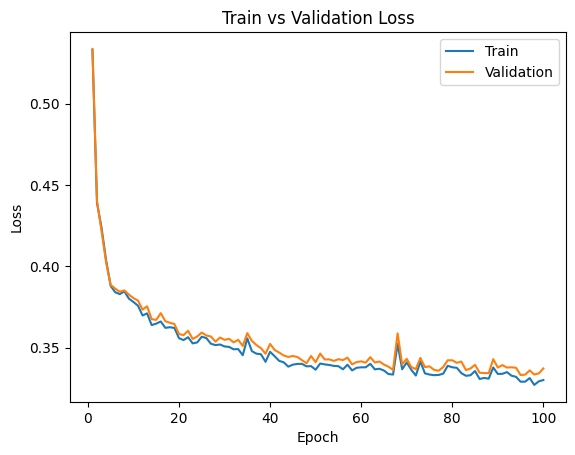

In [ ]:
model_path1 = get_model_name("AutoEncoder", batch_size=32, learning_rate=0.0005, num_epochs=99)
plot_training_curve(model_path1)

In [ ]:
# Increase the epochs by alot to allow model to learn weights
# Lower learning rate to accomdate for increase in epochs
# increase bathc size again to decrease noise
model4 = AutoEncoder()

train(model4, train_loader, valid_loader, num_epochs = 200, learning_rate=0.0001, batch_size=64)

Epoch 1: Train acc: 0.3079, Train loss: 0.6921 | Validation acc: 0.3076, Validation loss: 0.6924
Epoch 2: Train acc: 0.4402, Train loss: 0.5598 | Validation acc: 0.439, Validation loss: 0.561
Epoch 3: Train acc: 0.4402, Train loss: 0.5598 | Validation acc: 0.439, Validation loss: 0.561
Epoch 4: Train acc: 0.4605, Train loss: 0.5395 | Validation acc: 0.4595, Validation loss: 0.5405
Epoch 5: Train acc: 0.4646, Train loss: 0.5354 | Validation acc: 0.4623, Validation loss: 0.5377
Epoch 6: Train acc: 0.4785, Train loss: 0.5215 | Validation acc: 0.4755, Validation loss: 0.5245
Epoch 7: Train acc: 0.5184, Train loss: 0.4816 | Validation acc: 0.516, Validation loss: 0.484
Epoch 8: Train acc: 0.5338, Train loss: 0.4662 | Validation acc: 0.5297, Validation loss: 0.4703
Epoch 9: Train acc: 0.539, Train loss: 0.461 | Validation acc: 0.5366, Validation loss: 0.4634
Epoch 10: Train acc: 0.543, Train loss: 0.457 | Validation acc: 0.5413, Validation loss: 0.4587
Epoch 11: Train acc: 0.5491, Train loss

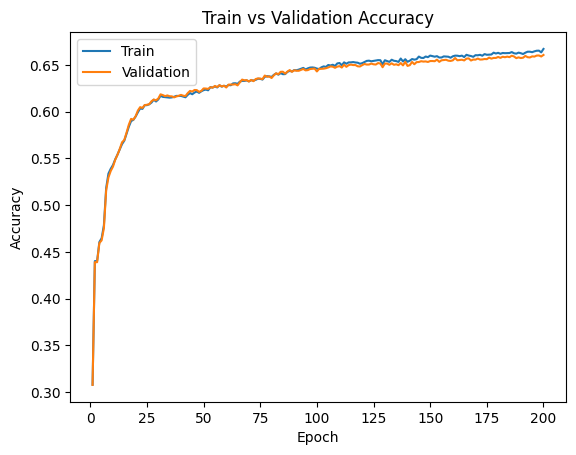

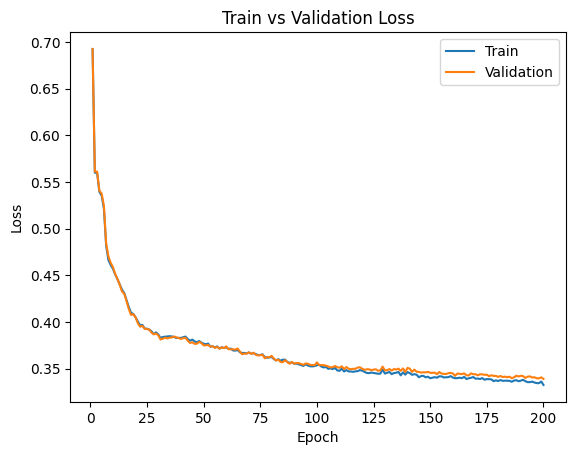

In [ ]:
model_path1 = get_model_name("AutoEncoder", batch_size=64, learning_rate=0.0001, num_epochs=199)
plot_training_curve(model_path1)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader =  torch.utils.data.DataLoader(testData, batch_size=128)

get_accuracy(model4, test_loader)

0.6612413194444444

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
# print(df_not_missing.shape)
baseModel = {}

for item in df_not_missing:
  newList = df_not_missing[item].value_counts()
  baseModel[item] = newList.idxmax()

print(baseModel)

{'age': 0.2602739726027397, 'yredu': 0.5333333333333333, 'capgain': 0.0, 'caploss': 0.0, 'workhr': 0.3979591836734694, 'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [ ]:
import operator
newList1 = df_not_missing["marriage"]
numer = operator.countOf(newList1, baseModel["marriage"])
denom = df_not_missing.shape[0]

print("base model test accuracy: " + str(round(numer/denom,4)*100))

base model test accuracy: 46.68


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy of the base model is lower than the accuracy of the neural network which is to be expected

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(testData[0])

{'work': 'Private',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Exec-managerial',
 'edu': 'Assoc-voc',
 'relationship': 'Husband',
 'sex': 'Male'}

I think it would be hard for a human to guess a person education based on their other features as the only useful one is their occupation which can be misleading. In this case the occupation is an executice manager which requires a high education and I dont think a human would be able to guess that this persons education is a associates degree

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
newData = zero_out_feature(testData[:1], "edu")[0]
predict = model4(torch.from_numpy(newData))
get_feature(predict.detach().numpy(), "edu")

'Bachelors'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(baseModel["edu"])

 HS-grad
